# Extracting CNN filter responses

This notebook demonstrates how to extract the learned features from a convolutional neural network and apply them to a MODIS granule.

## Code repository

This notebook is available from [this](https://github.com/simonpf/cloud_collocations) public repository.
To clone it simply run

    git clone https://github.com/simonpf/cloud_collocations
    

## Run this notebook using Docker

This notebook can also be run from inside a Docker container that comes with all dependencies installed.
If you have docker installed all you need to do is run:

    docker pull spfrnd/cloud_collocations:latest
    docker run -it -p 8888:8888 spfrnd/cloud_collocations:latest

And then inside the container:

    jupyter notebook --ip 0.0.0.0 --no-browser --allow-root
    
After copying the token, you should then be able to access this notebook from your browser.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy             as np
import sys
sys.path.append("..")
plt.style.use("../data/notebook")

## Loading the convolutional network

The trained network is a `CloudNetSimple` object, which is just a wrapper class around
keras, that builds a relatively simple convolutional neural network consisting of a few
convolutional layers followed by some dense layers.

The network used here is stored in `../models/cloud_net_simple_10.pckl`.

In [7]:
from cloud_colocations.cloud_net import CloudNetBase
cnn = CloudNetBase.load("../models/cloud_class.pckl")

/home/simon/build/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## Create a feature model

The `FeatureModel` class extracts the convolutional layers from the CNN. By retaining only the convolutional layers it becomes possible to apply the network to input of any size. The output generated by the feature model is **decreased  in the spatial dimensions** but increased along the **image channel or filter dimension**. The model loaded here has 32 filters in the last convolutional layer.

In [8]:
from cloud_colocations.cloud_net import FeatureModel
m = FeatureModel(cnn)

## Load a MODIS granule

We load a modis to get some data to apply the feature model to. Simply replace the file paths by two MODIS files of your choice.

In [9]:
from cloud_collocations.formats import ModisMyd03, ModisMyd021km

modis_filename     = "../cache/MYD021KM.A2009002.0715.006.2012058150852.hdf"
modis_file         = ModisMyd021km(modis_filename)
modis_geo_filename = "../cache/MYD03.A2009002.0715.006.2012054204904.hdf"
modis_geo_file     = ModisMyd03(modis_geo_filename)

Text(0.5,1,'Modis $12 \\mu$')

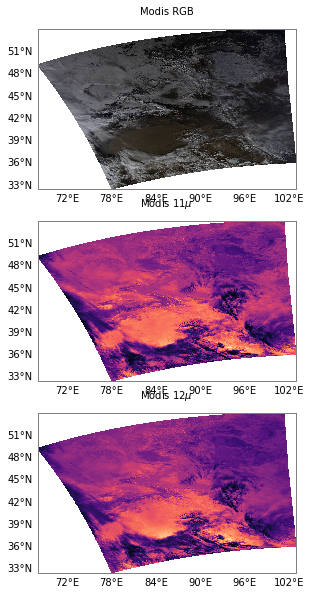

In [11]:
import matplotlib.gridspec as gridspec
from cloud_colocations.plots import plot_modis_granule_composite, plot_scalar_field
plt.figure(figsize = (5, 10))
gs = gridspec.GridSpec(3, 1)
plot_modis_granule_composite(modis_file, modis_geo_file, grid_spec = gs[0, 0])
ax = plt.gca()
ax.set_title("Modis RGB")

lats = modis_geo_file.get_latitudes()
lons = modis_geo_file.get_longitudes()

plot_scalar_field(modis_file.data[30, :, :], lats, lons,  grid_spec = gs[1,0])
ax = plt.gca()
ax.set_title("Modis $11 \mu$")

plot_scalar_field(modis_file.data[31, :, :], lats, lons, grid_spec = gs[2, 0])
ax = plt.gca()
ax.set_title("Modis $12 \mu$")

## Applying the feature model

The original model was trained on the MODIS $11\mu$, and $12\mu$ channels, therefore also the feature model expects the input to have two channels along the first dimension.

In [12]:
filter_response = m.apply(modis_file.data[[30, 31], :, :])

As mentioned above, the **image size of the filter responses is reduced with respect to the input granules**. To match the filter responses to the input data, the `FeatureModel` class provides the `resample_coordinates` function that transforms the geolocation data to match the filter responses.

In [13]:
lats_f = m.resample_coordinates(lats)
lons_f = m.resample_coordinates(lons)

### Plotting all features

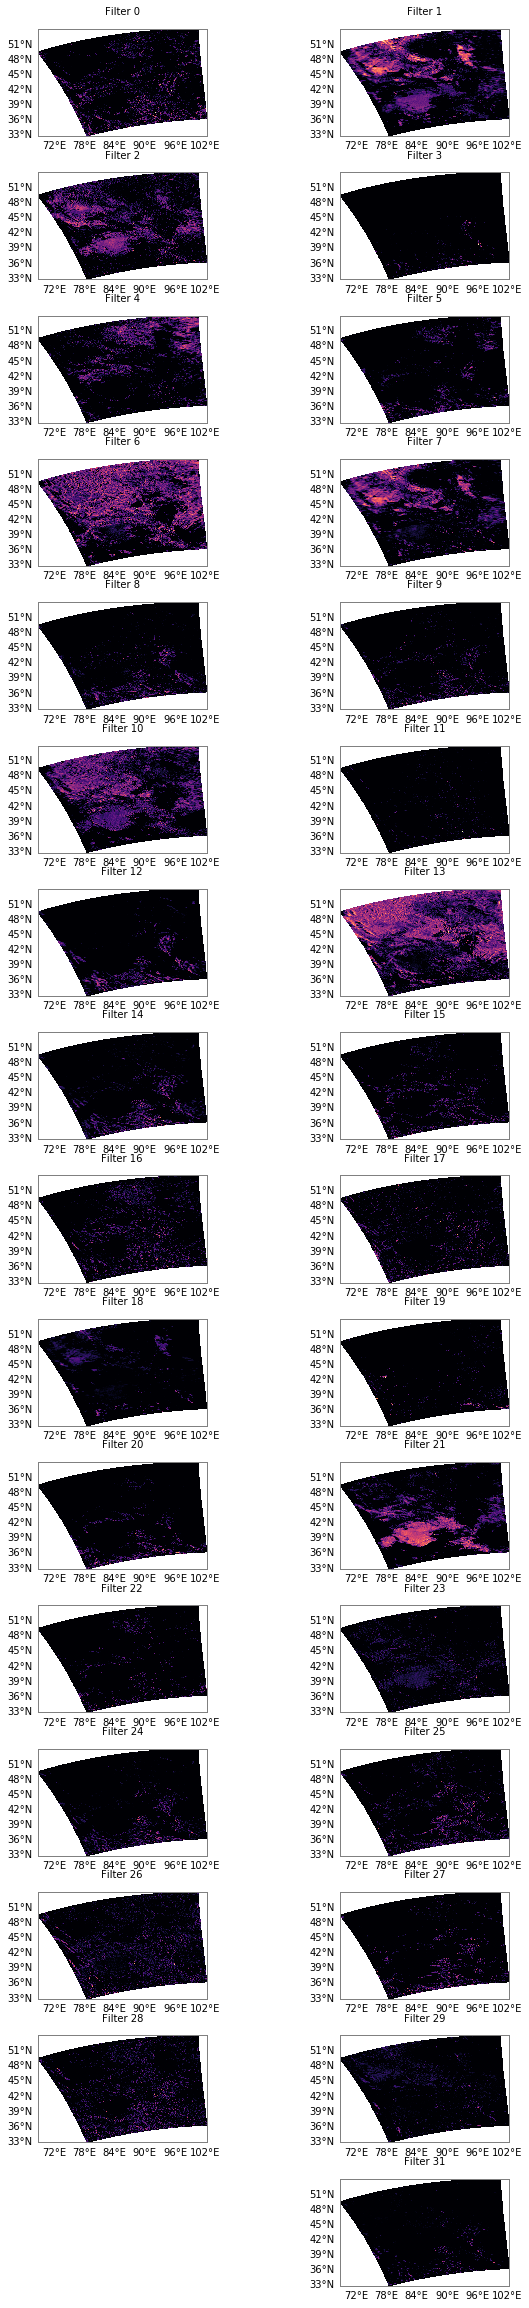

In [14]:
from matplotlib.colors import Normalize, LogNorm
f = plt.figure(figsize = (10, 32))
gs = gridspec.GridSpec(16, 2)

for i in range(32):
    
    f_max = np.max(np.abs(filter_response[0, i, :, :]))
    f_min = np.min(np.abs(filter_response[0, i, :, :]))
    
    plot_scalar_field(filter_response[0, i, :, :], lats_f, lons_f,
                      grid_spec = gs[i // 2, i % 2])
    ax = plt.gca()
    ax.set_title("Filter {0}".format(i))
    plt.tight_layout()

### Only interesting responses

Some of the filters do not seem to contain valuable information at least plotted in this way. Whether or not they contain valuable information for a retrieval remains to be seen.

Let's plot again the RGB and input granules as well as the more interesting filter responses, to have them side by side.

/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:233: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:233: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


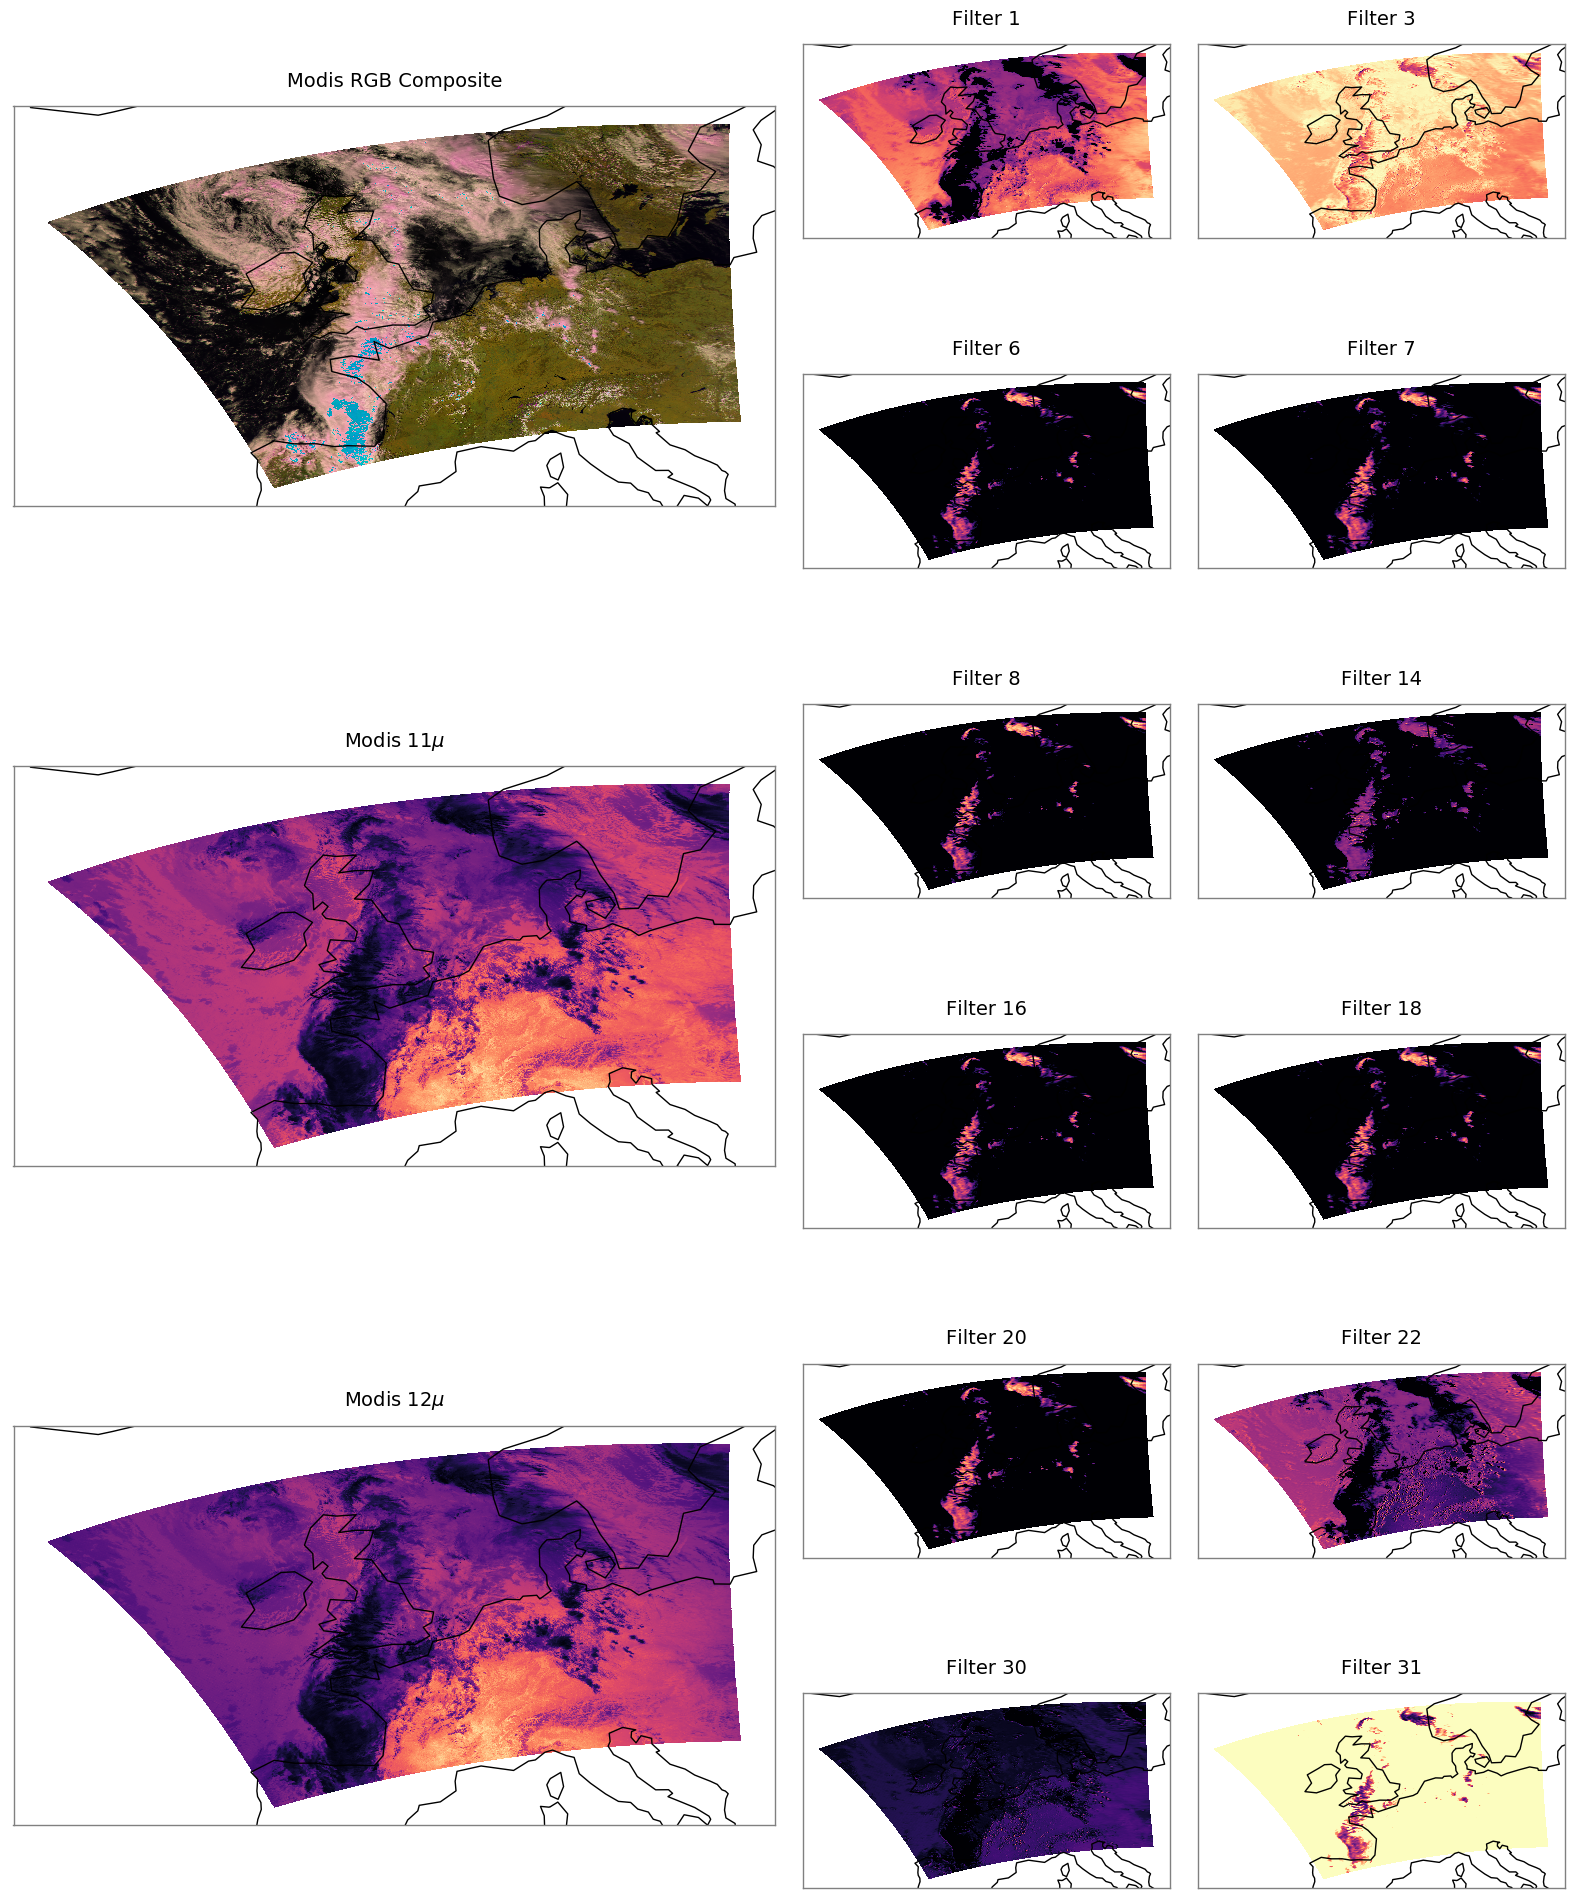

In [148]:
import matplotlib.gridspec as gridspec

plt.figure(figsize = (16, 20))
gs = gridspec.GridSpec(6, 4)

gs1 = gs[0:2, :2]
gs2 = gs[2:4, :2]
gs3 = gs[4:6, :2]

gss = [gs[i // 2, 2 + i % 2] for i in range(12)]

plot_modis_granule_composite(modis_file, modis_geo_file, grid_spec = gs1)
ax = plt.gca()
ax.set_title("Modis RGB Composite")

lats = modis_geo_file.get_latitudes()
lons = modis_geo_file.get_longitudes()

plot_scalar_field(modis_file.data[30, :, :], lats, lons,  grid_spec = gs2)
ax = plt.gca()
ax.set_title("Modis $11\mu$")

plot_scalar_field(modis_file.data[31, :, :], lats, lons, grid_spec = gs3)
ax = plt.gca()
ax.set_title("Modis $12\mu$")

inds = [1, 3, 6, 7, 8, 14, 16, 18, 20, 22, 30, 31]
for i, j in enumerate(inds):
    plot_scalar_field(filter_response[0, j, :, :], lats_f, lons_f, grid_spec = gss[i])
    ax = plt.gca()
    ax.set_title("Filter {0}".format(j))
    
plt.tight_layout()
plt.savefig("../plots/filter_responses.png", bbox_inches = "tight")

In [24]:
lon_lims = [85, 95]
lat_lims = [40, 50]

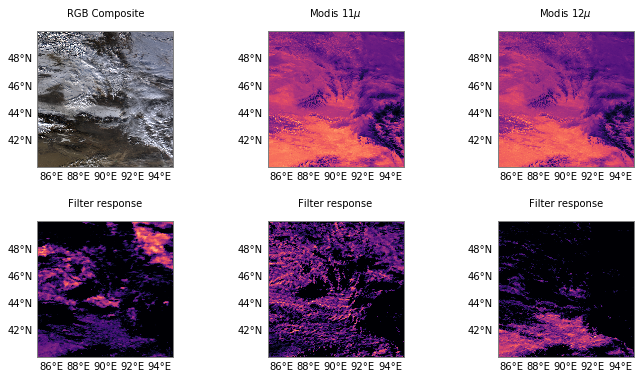

In [42]:
from matplotlib import ticker

f  = plt.figure(figsize = (12, 6))
gs = gridspec.GridSpec(2, 3, wspace = 0.1, hspace = 0.4)
filters = [1, 6, 21]

ax, _, gl = plot_modis_granule_composite(modis_file, modis_geo_file, grid_spec = gs[0, 0], gain = 0.5)
ax.set_xlim(lon_lims)
ax.set_ylim(lat_lims)
ax.set_title("RGB Composite")

gl.xlocator = ticker.MaxNLocator(5)
gl.ylocator = ticker.MaxNLocator(5)

ax, _, gl = plot_scalar_field(modis_file.data[30, :, :], lats, lons,  grid_spec = gs[0,1])
ax.set_xlim(lon_lims)
ax.set_ylim(lat_lims)
ax.set_title("Modis $11 \mu$")
gl.xlocator = ticker.MaxNLocator(5)
gl.ylocator = ticker.MaxNLocator(5)

ax, _, gl = plot_scalar_field(modis_file.data[31, :, :], lats, lons, grid_spec = gs[0, 2])
ax.set_xlim(lon_lims)
ax.set_ylim(lat_lims)
ax.set_title("Modis $12 \mu$")

gl.xlocator = ticker.MaxNLocator(5)
gl.ylocator = ticker.MaxNLocator(5)

for j in range(3):
    ax, _, gl = plot_scalar_field(filter_response[0, filters[j], :, :], lats_f, lons_f, grid_spec = gs[1, j])
    ax.set_xlim(lon_lims)
    ax.set_ylim(lat_lims)
    ax.set_title("Filter response")
    gl.xlocator = ticker.MaxNLocator(5)
    gl.ylocator = ticker.MaxNLocator(5)
    
f.savefig("../plots/filter_responses.png")